In [1]:
import yfinance as yf 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from pandas_datareader import data as pdr 
import datetime as dt
yf.pdr_override()

In [4]:
stock = 'TSLA'
start = "2010-01-01"
end = "2020-04-30"
df = pdr.get_data_yahoo('TSLA', start=start, end=end)
df['HighS'] = df['High'].shift(1)
df['LowS'] = df['Low'].shift(1)
df['CloseS'] = df['Close'].shift(1)
print(df.tail())

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-04-23  145.520004  146.800003  140.626007  141.126007  141.126007   
2020-04-24  142.162003  146.145996  139.636002  145.029999  145.029999   
2020-04-27  147.522003  159.897995  147.000000  159.750000  159.750000   
2020-04-28  159.128006  161.000000  151.337997  153.824005  153.824005   
2020-04-29  158.033997  160.639999  156.632004  160.102005  160.102005   

              Volume       HighS        LowS      CloseS  
Date                                                      
2020-04-23  13236700  146.800003  137.742004  146.421997  
2020-04-24  13237600  146.800003  140.626007  141.126007  
2020-04-27  20681400  146.145996  139.636002  145.029999  
2020-04-28  15222000  159.897995  147.000000  159.750000  
2020-04-29  16216000  161.000000  151.337997  153.824005  

In [5]:
#lists used to store open positions
openLong = []
openShort = []

In [6]:
#lists used to store markers for graphic position open as close
shortDate = []
shortValue = []
longDate = []
longValue = []
closeLongDate = []
closeLongValue = []
closeShortDate = []
closeShortValue = []

In [7]:
# variables for printable data, like profit, win/loss and total amount of trades
total = 0
profit = 0
win = 0
lose = 0

In [8]:
#index variable
n = 0

In [9]:
#Relative Strength Index
period = 14
data = df.copy()
high = data['High']
low = data['Low']
close = data['Close']
df['delta'] = df['Close'].diff()
df['dGain'], df['dLoss'] = df['delta'].copy(), df['delta'].copy()
df['dGain'][df['dGain'] < 0] = 0
df['dGain'][0] = 0
df['dLoss'][df['dLoss'] > 0] = 0
df['dLoss'][0] = 0
df['Rolup'] = df['dGain'].rolling(period).mean()
df['RolDown'] = df['dLoss'].rolling(period).mean().abs()
df['RSI'] = 100 - (100/(1 + (df['Rolup'] / df['RolDown'])))
#RSI Resistance Levels
upResistance = []
downResistance = []
upResistance_num = 70
downResistance_num = 30
for i in df['Close']:
    upResistance.append(upResistance_num)
    downResistance.append(downResistance_num)

In [10]:
#start for loop to test strategy
for val in df['RSI']:
    #if conditions met, open long position
    if val < downResistance_num:
        #store price points and index to mark on graph
        longValue.append(df['Close'][n])
        longDate.append(df['Close'].index[n])
        #remembers the long positions
        openLong.append(df['Close'][n])
    #if consitions met, open short position
    if val > upResistance_num:
        #store price points and index to mark on graph
        shortValue.append(df['Close'][n])
        shortDate.append(df['Close'].index[n])
        #remembers to short positions
        openShort.append(df['Close'][n])
    #if conditions are met closes open long position
    if len(openLong) > 0 and val >= 55:
        closeLongDate.append(df['Close'].index[n])
        closeLongValue.append(df['Close'][n])

        #subtract closing price from all open long positions stored in a list
        openLong = [df['Close'][n] - x for x in openLong]
        profit += sum(openLong)

        #total long trades, won long trades, lost long trades
        total += len(openLong)
        win += len([i for i in openLong if i>=0])
        lose += len([i for i in openLong if i < 0])

        #empties list of open positions since they are now closed
        openLong = []
    
    if len(openShort)>0 and val <= 45:
        closeShortDate.append(df['Close'].index[n])
        closeShortValue.append(df['Close'][n])

        #subtract closing price from all open short positions stored in a list
        openShort = [x-data['Close'][n] for x in openShort]
        profit += sum(openShort)

        #total short trades, won short trades, lost short trades
        total += len(openShort)
        win += len([i for i in openShort if i >= 0])
        lose += len([i for i in openShort if i < 0])

        #empties list of open positions since they are now closed
        openShort = []

    #index incrementing
    n+=1

In [11]:
#print return from test
print("Total amount of orders executed:", total)
print("Numbers of winning trades", win)
print("Numbers of losing trades", lose)
if total != 0:
    print("Hitrate:", (win/total)*100, "%")
print(f"Profit: ${profit}")

Total amount of orders executed: 685
Numbers of winning trades 386
Numbers of losing trades 299
Hitrate: 56.35036496350365 %
Profit: $-2162.0897331237793


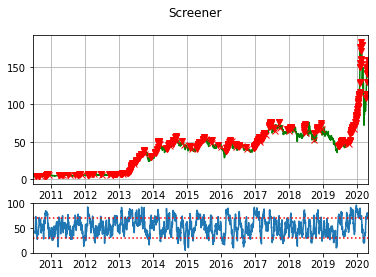

In [12]:
#plot graphs and markers

#plot the graph
fig, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]})
fig.suptitle('Screener')

#Main graph window
axs[0].plot(df['Close'], color = "g")
axs[0].grid()
axs[0].set_xlim([df['Close'].index[0], df['Close'].index[len(df['Close'])-1]])

#short position markers
axs[0].plot(shortDate, shortValue, "rv")

#long position markers
axs[0].plot(closeShortDate, closeShortValue, "rx")

# RSI
axs[1].plot(df['RSI'])
axs[1].set_ylim([0, 100])
axs[1].set_xlim([df['Close'].index[0], df['Close'].index[len(df['Close']) - 1]])
# RSI Oversold, Overbought
axs[1].axhline(y=70, color='r', linestyle='dotted')
axs[1].axhline(y=30, color='r', linestyle='dotted')
plt.show()